# Stock Deep Recurrent Q-Network 
This notebook provides an implementation of a Deep Double Recurrent Q-Network which can solve Partially Observable Markov Decision Processes. This notebook applies the technique on time series.

In [1]:
import numpy as np
import math
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
import os
import csv
import itertools
%matplotlib inline
import time
from sklearn.preprocessing import MinMaxScaler
from helper import *
from StockEnv import StockEnv
import pandas as pd
from GeometricBrownianMotion import * 
from MCSAmericanOptionPricing import *

seed = 1#time.time()
random.seed(seed)
print('Seed is:' + str(seed))

/misc/home/reco/fathanab/anaconda3/envs/tfenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/misc/home/reco/fathanab/anaconda3/envs/tfenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/misc/home/reco/fathanab/anaconda3/envs/tfenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/misc/home/re

Seed is:1


### Variable settings

In [2]:
risk_free_rate = 5/100
mu = risk_free_rate
sigma = 0.20
num_seeds = 200

In [3]:
save_model_freq = 10000 #5000
Normalization = False
Window_Normalization = False #True #False
test_data_ratio = 0.2 #0.3 # 0.2

architecture = 0 #3 #0 #1 #2 #3 #4 #5
nbFilters = 32 #16 #1
paddingType = 'same' #'causal' # 'valid'
huber_loss = False #True #False
dueling_type = 'avg' #'max' 'naive'
mask_type = 'default' #'maskFirstHalf' # 'maskByWeights' 'default'
apply_dropout = False
batch_size = 32 #16 #32 #128 #60 #20 #4 #How many experience traces to use for each training step.
memory_capacity = 3000 #1000
learning_rate = 0.0025 #0.01 0.025 0.0025 0.0001
apply_grad_clipping = True
grad_clipping = 5 # Maybe test with bigger values, e.g. 40 or 30
optimizer_type = 'Adam' # 'GradientDescent' 'RMSProp'

Colab = False
scriptDirectory = os.getcwd() #"C:\Code_RL\2019_11_21_shuffled_GBM_version" #"C:\\Code_RL" # os.getcwd()

history_t = 15 #5 #15 #2 #15 ##
option_T = 50 #65 #50 #100 #365 #100 #200 #365 #65 #30 #15 #40 #30 ##
#build_warm_up_state_t = option_T // 3 #option_T // 2
input_size = history_t + 2
is_training = True

min value of data: 50.55108446618011, max value of data: 75.71320001340916
train_size: 743
test_size: 185
min value of data: 160.41750891209688, max value of data: 232.0053569320216
train_size: 743
test_size: 185
min value of data: 117.39052913848273, max value of data: 239.65281150191407
train_size: 743
test_size: 185
min value of data: 61.68717100789021, max value of data: 93.3981808897496
train_size: 743
test_size: 185
min value of data: 56.87545268912853, max value of data: 90.88754177619106
train_size: 743
test_size: 185
min value of data: 94.06358565243866, max value of data: 245.37303421922587
train_size: 743
test_size: 185
min value of data: 129.93675878153329, max value of data: 232.31137151669466
train_size: 743
test_size: 185
min value of data: 129.9534825322404, max value of data: 258.1770676311054
train_size: 743
test_size: 185
min value of data: 35.20913894154504, max value of data: 65.18331821536977
train_size: 743
test_size: 185
min value of data: 101.39621501443278, ma

min value of data: 37.66059137586361, max value of data: 84.42491508385788
train_size: 743
test_size: 185
min value of data: 120.27641067941983, max value of data: 187.95133060324198
train_size: 743
test_size: 185
min value of data: 78.26540749320638, max value of data: 132.09175503181794
train_size: 743
test_size: 185
min value of data: 52.26130653266332, max value of data: 104.37908319099631
train_size: 743
test_size: 185
min value of data: 145.06090276461327, max value of data: 270.3896765553696
train_size: 743
test_size: 185
min value of data: 168.15603729029849, max value of data: 385.1328010889352
train_size: 743
test_size: 185
min value of data: 179.6991059364167, max value of data: 301.8235053109573
train_size: 743
test_size: 185
min value of data: 127.31481119807711, max value of data: 227.51434330967498
train_size: 743
test_size: 185
min value of data: 170.91435824284528, max value of data: 366.12010683502103
train_size: 743
test_size: 185
min value of data: 72.8811800158935,

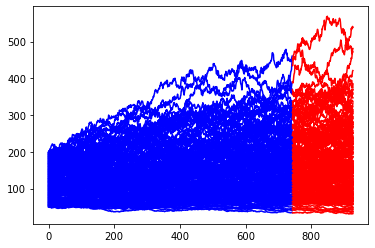

In [5]:
#Generate stocks data
stocks_data, _ = GBM(num_seeds, is_training).generate_stock_paths(mu, sigma, 928, num_seeds, is_training)
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_data in stocks_data:
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_data, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r') 

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 4237
num_episodes_per_epoch: 135600
min value of stock: 126.80873014680922, max value of stock: 229.2135004855168


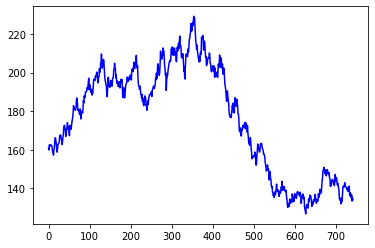

In [6]:
#env = StockEnv(train_data, risk_free_rate, history_t=history_t, option_T=option_T)
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
build_warm_up_state_t = env.get_build_warm_up_state()
trace_length = option_T - build_warm_up_state_t
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

# Select day of price over history bigger than option price (B.M.) [Benchmark]

In [7]:
r = risk_free_rate #10/100
#n = 400
isRiskNeutral = True #False
num_episodes = env.get_total_num_episodes_per_epoch() #max_num_observations - option_T
max_epLength = option_T
summaryLength = 100 #Number of epidoes to periodically save for analysis
summaryAverageReward = 5000

### Experience Replay

These classes allow us to store experies and sample then randomly to train the network.
Episode buffer stores experiences for each individal episode.
Experience buffer stores entire episodes of experience, and sample() allows us to get training batches needed from the network.

In [8]:
class experience_buffer():
    def __init__(self, buffer_size = memory_capacity, build_warm_up_state_t=build_warm_up_state_t):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
    
    def sample(self,batch_size):
        sampled_episodes = random.sample(self.buffer,batch_size)
        #sampled_episodes = np.array(sampled_episodes)
        sampled_episodes = self.processEpisodes(sampled_episodes)
        return np.reshape(sampled_episodes,[-1,5])
    
    def processEpisodes(self,sampled_episodes):
        sampledTraces = []
        for episode in sampled_episodes:
            sampledTraces.append(episode[build_warm_up_state_t:])
        sampledTraces = np.array(sampledTraces)
        return sampledTraces

### Training the network

In [9]:
#Setting the training parameters
num_layers = 1 #2 #3 # Number of layer of LSTM
h_size = 512 #256 #512 #128 #512 #256 #512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
keep_prob = 0.8
dropout = 1 - keep_prob  # dropout amount
update_freq = 5 #30 #10 #5 #How often to perform a training step.
update_online_freq = 5 #10 #5 #3 #5
update_target_freq = 30 #300 #30
#gamma = discount_factor #.99 #.95 #1 #Discount factor on the target Q-values
gamma = env.get_discount_factor(1) # discount for 1 day
startE = 1 #0.1 #1 #Starting chance of random action
endE = 0.1 #0.01 #0.1 #Final chance of random action
num_episodes = env.get_total_num_episodes_per_epoch()*5 #30 #50000 #20000 #100000 #20000 #3000 #20000 #30000 #10000 #4000 #100000 #40000
pre_train_episodes = int(memory_capacity * 0.1) # 0.25 300 #300 #200 #600 #200
annealing_episodes = int(num_episodes * 0.3) #4*memory_capacity #0.7*memory_capacity #400 #memory_capacity #400
pre_exploitation_episodes = int(num_episodes * 0.6)
annealing_exploitation_episodes = int(num_episodes * 0.25)
exploitationE =  0.01 #0.008 #0.02
load_model = False #Whether to load a saved model.
path = os.path.join(scriptDirectory, 'savedModel') #The path to save our model to.
max_epLength = option_T #env.get_max_episode_time() #option_T + build_warm_up_state_t
summaryLength = 100 #Number of epidoes to periodically save for analysis
summaryAverageReward = 5000
tau = 0.001 # learning rate (also referred to as step size) for target network
softUpdate = False # use soft or hard updates
#trained_model_name = os.path.join(path, 'architecture' + str(architecture) + '-option_T' + str(option_T) + '-history_t' + str(history_t) + '-num_episodes' + str(num_episodes) + '-tau' + str(tau) + '-softUpdate' + str(softUpdate) + '-dropout' + str(dropout) + '-mask' + str(mask_type) + '-dueling_type' + str(dueling_type) + '-So' + str(So) + '-strike_price' + str(strike_price) + '-mu' + str(mu) + '-sigma' + str(sigma) + '-num_seeds' + str(num_seeds))
trained_model_name = os.path.join(path, 'architecture' + str(architecture) + '-option_T' + str(option_T) + '-history_t' + str(history_t) + '-num_episodes' + str(num_episodes) + '-tau' + str(tau) + '-softUpdate' + str(softUpdate) + '-dropout' + str(dropout) + '-mask' + str(mask_type) + '-dueling_type' + str(dueling_type))
final_trained_model_name = trained_model_name + '-final'
exploration_type = 'Random'
print('#num_episodes: ' + str(num_episodes))
print('#trace_length: ' + str(trace_length))
#print('#discount_factor: ' + str(discount_factor))
print('#gamma: ' + str(gamma))

#num_episodes: 678000
#trace_length: 38
#gamma: 0.9998016069840849


### Testing the network

In [10]:
#e = 0.03 #0.01 #The chance of chosing a random action
load_model = True #Whether to load a saved model.
is_training = False

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 750
num_episodes_per_epoch: 24000
min value of stock: 125.64229401508895, max value of stock: 175.81496892998706


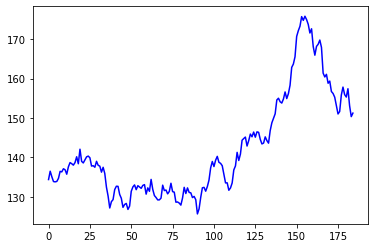

In [11]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

# Select day of price over history bigger than option price (B.M.) [Benchmark]

In [12]:
r = risk_free_rate
isRiskNeutral = True

In [13]:
begin_time = time.time()

test = 'BM' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:1'):
    set_seed(seed)    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MinValue' or test == 'Normal' or test == 'BM':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MinValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] <= min(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'BM':
              #if j == sell_time and env.get_payoff() > 0:
              T_BM, S0_BM, k_BM, mu_BM, sigma_BM, n_BM = env.getParameters()
              if env.get_time() >= build_warm_up_state_t and env.get_payoff() > 0 and (env.binomialTreeExercise
                (T_BM, S0_BM, k_BM, risk_free_rate, mu_BM, sigma_BM, n_BM, isRiskNeutral)[1] == True or j == max_epLength - 1):
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]
                
print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')


episode 100: 	0.02606743446380694	15.11
episode 200: 	0.02817497958072551	15.99
episode 300: 	0.03232173398039594	16.06
episode 400: 	0.02189226930201269	13.89
episode 500: 	0.028223034410437588	15.49
episode 600: 	0.025739392975288822	16.12
episode 700: 	0.026094790515552142	14.6
episode 800: 	0.027998792951040557	14.16
episode 900: 	0.029625670482263104	15.38
episode 1000: 	0.022241938778380748	14.53
episode 1100: 	0.033345934629629606	14.69
episode 1200: 	0.03096407857876342	16.31
episode 1300: 	0.023680530008880644	10.97
episode 1400: 	0.028383731396408172	16.62
episode 1500: 	0.03147695423262364	18.64
episode 1600: 	0.024619515493616122	13.59
episode 1700: 	0.024929541871243223	13.78
episode 1800: 	0.023813556587030427	14.86
episode 1900: 	0.02757931043033416	14.68
episode 2000: 	0.023814200207531354	13.04
episode 2100: 	0.033170350990240044	18.56
episode 2200: 	0.026867374204812545	16.97
episode 2300: 	0.0317986746018438	15.42
episode 2400: 	0.026821753138154044	16.04
episode 25

episode 18700: 	0.028210015513999674	16.6
episode 18800: 	0.026393698749238612	13.93
episode 18900: 	0.02881889992224637	15.46
episode 19000: 	0.027061688440714486	14.77
episode 19100: 	0.03254195391268713	13.78
episode 19200: 	0.022662591930650507	12.87
episode 19300: 	0.02872087084916053	14.29
episode 19400: 	0.026797065124566956	15.54
episode 19500: 	0.03234825225552645	17.17
episode 19600: 	0.026477800473339332	12.53
episode 19700: 	0.03486654026496872	16.59
episode 19800: 	0.02527361949166031	13.1
episode 19900: 	0.03282103330883007	16.46
episode 20000: 	0.02749368554484824	16.39
#Average reward per episode 20000: 0.02758689317506657
episode 20100: 	0.03042966050828366	18.43
episode 20200: 	0.023972648783064997	11.43
episode 20300: 	0.029190157806161136	16.13
episode 20400: 	0.022629065980554825	13.98
episode 20500: 	0.03176758466389308	16.64
episode 20600: 	0.02380940398051177	12.55
episode 20700: 	0.029165380966454914	13.83
episode 20800: 	0.022781036665736703	12.67
episode 2090

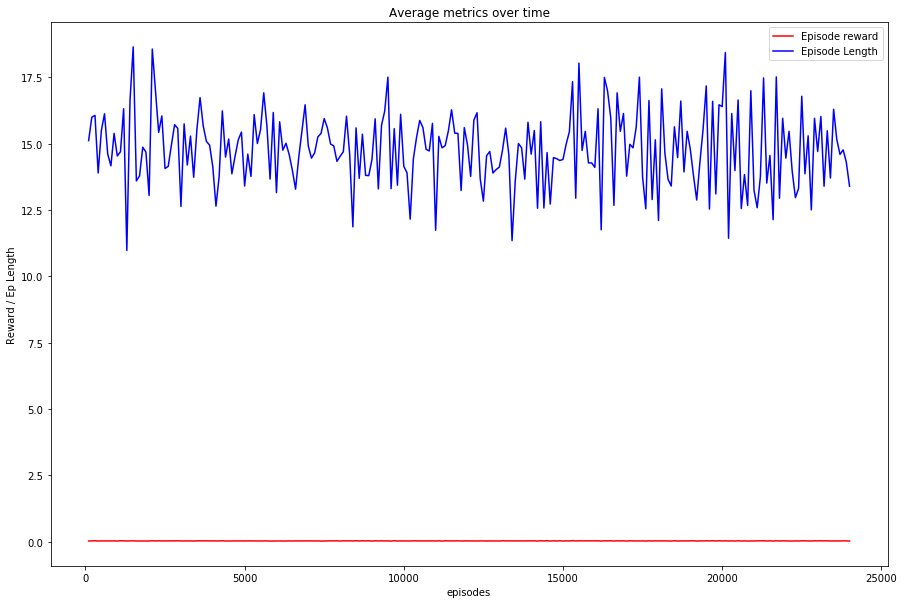

In [14]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

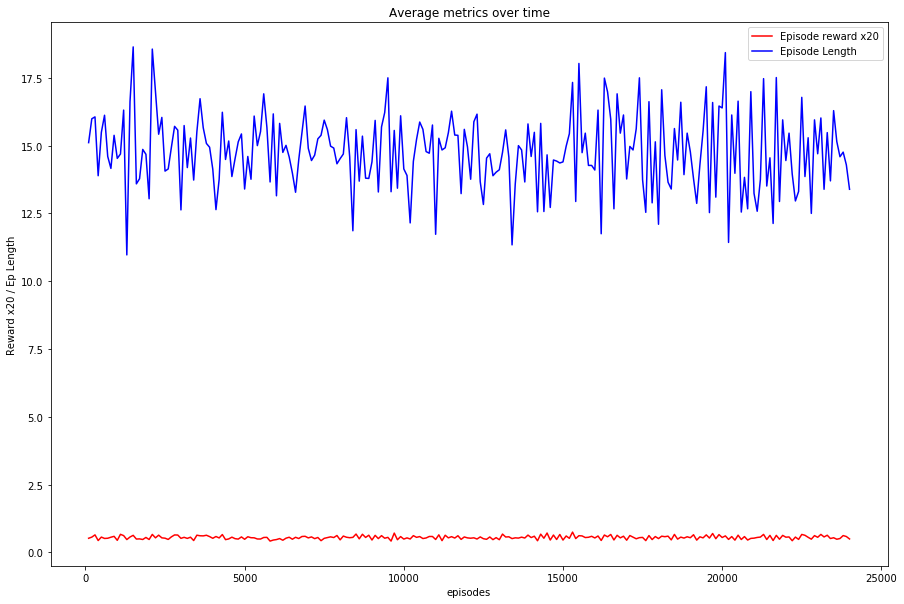

In [15]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

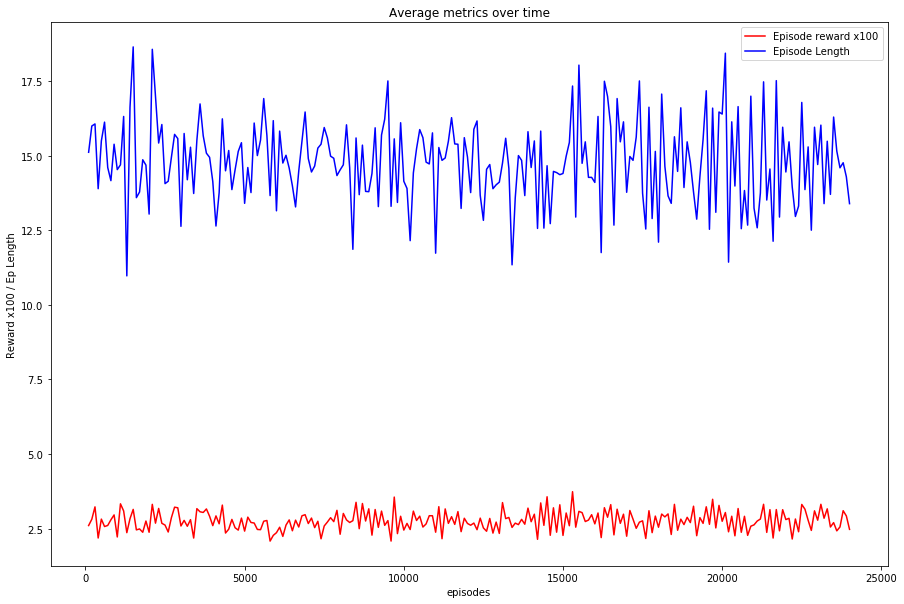

In [16]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

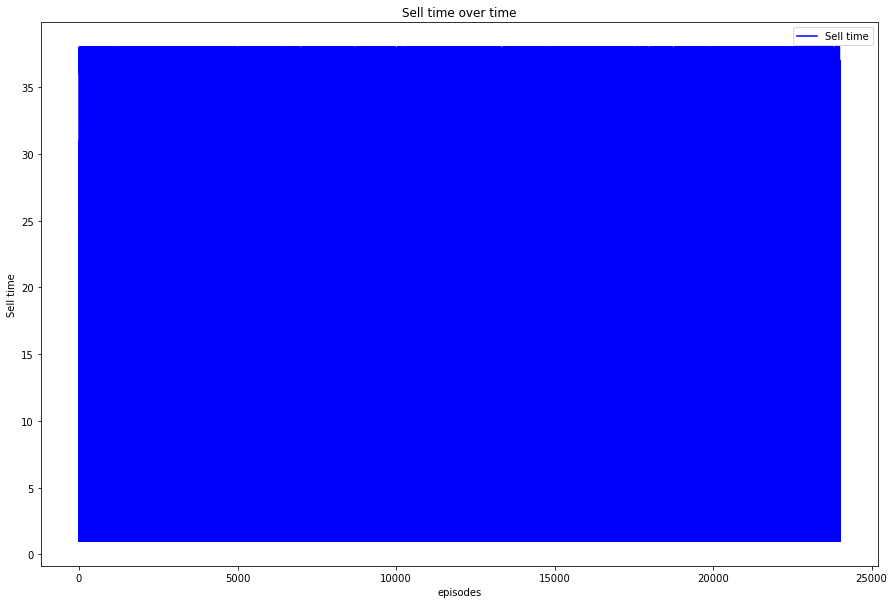

In [17]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

### Load the game environment

Setting our environment

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 4237
num_episodes_per_epoch: 135600
min value of stock: 126.80873014680922, max value of stock: 229.2135004855168


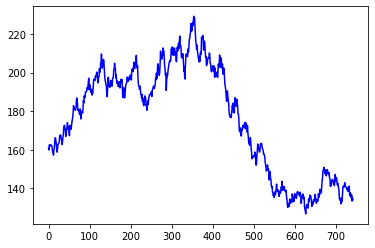

In [18]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
build_warm_up_state_t = env.get_build_warm_up_state()
trace_length = option_T - build_warm_up_state_t
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

# Select day of price over history bigger than option price (B.M.) [Benchmark]

In [19]:
r = risk_free_rate
isRiskNeutral = True #False
num_episodes = env.get_total_num_episodes_per_epoch() #max_num_observations - option_T
max_epLength = option_T
summaryLength = 100 #Number of epidoes to periodically save for analysis
summaryAverageReward = 5000

In [20]:
begin_time = time.time()

test = 'BM' #'Random'

#myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:1'):
    set_seed(seed)    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0

        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MinValue' or test == 'Normal' or test == 'BM':
          sell_time = -1

        while j < max_epLength: 
            if test == 'MinValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] <= min(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'BM':
              #if j == sell_time and env.get_payoff() > 0:
              T_BM, S0_BM, k_BM, mu_BM, sigma_BM, n_BM = env.getParameters()
              if env.get_time() >= build_warm_up_state_t and env.get_payoff() > 0 and (env.binomialTreeExercise
                (T_BM, S0_BM, k_BM, risk_free_rate, mu_BM, sigma_BM, n_BM, isRiskNeutral)[1] == True or j == max_epLength - 1):
                a = 1
              else:
                a = 0

            s1P,r,d = env.step(a)

            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break

        #myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()

        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR)
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))

option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.02721358125142463	13.8
episode 200: 	0.01992510235040332	14.3
episode 300: 	0.03261242371316785	15.63
episode 400: 	0.02070097615404798	10.66
episode 500: 	0.024703851500950124	13.23
episode 600: 	0.020987769511572413	13.17
episode 700: 	0.028683852474101726	15.18
episode 800: 	0.025902951050222077	13.12
episode 900: 	0.024033368559175473	13.42
episode 1000: 	0.0236407471771861	12.88
episode 1100: 	0.025698352659600424	13.93
episode 1200: 	0.02715638275620247	12.75
episode 1300: 	0.02690378010075735	15.7
episode 1400: 	0.025357718508037638	13.9
episode 1500: 	0.02786663235829867	13.34
episode 1600: 	0.02783406332928248	13.57
episode 1700: 	0.02506937231615655	15.1
episode 1800: 	0.02264933072827883	13.11
episode 1900: 	0.025573592854419718	14.51
episode 2000: 	0.023684120985149194	12.9
episode 2100: 	0.02692009595221231	14.56
episode 2200: 	0.0297955526658114	14.4
episode 2300: 	0.02544086626387597	13.09
episode 2400: 	0.023890510241220096	14.4
episode 2500: 	0.02909436

episode 19300: 	0.026178755279789002	13.81
episode 19400: 	0.029041851141152934	14.16
episode 19500: 	0.026956818837527076	14.26
episode 19600: 	0.026120972703826618	14.57
episode 19700: 	0.027759962988590795	14.73
episode 19800: 	0.031012611284279158	16.82
episode 19900: 	0.026717469159437863	14.22
episode 20000: 	0.024955286919591434	14.98
#Average reward per episode 20000: 0.02668789003723204
episode 20100: 	0.025281442166750524	12.65
episode 20200: 	0.030579625853862775	13.98
episode 20300: 	0.025342183986729366	12.94
episode 20400: 	0.022243217010250685	12.2
episode 20500: 	0.023320091364537738	15.7
episode 20600: 	0.025710416512139015	15.31
episode 20700: 	0.024686612097315135	14.96
episode 20800: 	0.024175669631888327	13.12
episode 20900: 	0.03201875853581576	15.81
episode 21000: 	0.030542352382021146	15.87
episode 21100: 	0.02791124325100014	12.65
episode 21200: 	0.027258589900620883	13.54
episode 21300: 	0.023347338380848664	13.28
episode 21400: 	0.029636374077026097	14.96
epi

episode 38100: 	0.026129341227178898	13.36
episode 38200: 	0.023169570709964882	13.46
episode 38300: 	0.021156865890031618	15.17
episode 38400: 	0.024702911506744037	15.81
episode 38500: 	0.024727885302912832	14.43
episode 38600: 	0.02450276526493517	12.89
episode 38700: 	0.027545330102172506	15.5
episode 38800: 	0.03065531361909878	13.9
episode 38900: 	0.025411872205739948	12.68
episode 39000: 	0.027177765403798966	13.49
episode 39100: 	0.026365707833792915	13.91
episode 39200: 	0.027062983414086864	14.34
episode 39300: 	0.02836518013860684	14.89
episode 39400: 	0.030456958891525485	16.09
episode 39500: 	0.025049647736003103	13.1
episode 39600: 	0.028865483182123782	15.82
episode 39700: 	0.022291684021416312	12.56
episode 39800: 	0.02767469181881367	14.82
episode 39900: 	0.021703985548127108	11.91
episode 40000: 	0.026598002408493415	12.05
#Average reward per episode 40000: 0.026602403187248307
episode 40100: 	0.02544927182463376	13.22
episode 40200: 	0.022469685173037976	15.4
episode

episode 56900: 	0.019922849006834713	11.39
episode 57000: 	0.031850719236421736	15.61
episode 57100: 	0.030180929999707787	15.82
episode 57200: 	0.030347896454820902	17.34
episode 57300: 	0.025672966507347725	14.21
episode 57400: 	0.024984001948665187	15.36
episode 57500: 	0.024538988929986513	12.94
episode 57600: 	0.02245155988051065	13.02
episode 57700: 	0.022555948155415596	14.74
episode 57800: 	0.030637986584452857	16.29
episode 57900: 	0.028550006691221663	13.13
episode 58000: 	0.026305875301842724	15.19
episode 58100: 	0.022585754578577227	14.13
episode 58200: 	0.026294650322342322	15.83
episode 58300: 	0.026048051608308923	13.53
episode 58400: 	0.02580951533409519	13.27
episode 58500: 	0.026262624453816313	13.46
episode 58600: 	0.01921911138981281	12.44
episode 58700: 	0.014613082072450817	12.63
episode 58800: 	0.031261117803960195	15.44
episode 58900: 	0.02503570428875259	15.13
episode 59000: 	0.02956135369961902	18.66
episode 59100: 	0.023894070316226666	10.66
episode 59200: 	

episode 75700: 	0.02155173938155771	14.11
episode 75800: 	0.02689590410162684	13.02
episode 75900: 	0.026650729178889422	13.13
episode 76000: 	0.029417312371188543	13.54
episode 76100: 	0.02580218814442151	13.28
episode 76200: 	0.023425951935705958	12.13
episode 76300: 	0.025920589639981752	13.59
episode 76400: 	0.028453041455656577	16.01
episode 76500: 	0.03327784648658282	15.62
episode 76600: 	0.022104244107413757	12.7
episode 76700: 	0.021573712710571732	13.97
episode 76800: 	0.021909271482584765	12.31
episode 76900: 	0.02435382290871495	12.45
episode 77000: 	0.036678754087408325	14.79
episode 77100: 	0.02733571571721007	13.79
episode 77200: 	0.024933217748250032	14.93
episode 77300: 	0.027602429527498192	12.76
episode 77400: 	0.025497585156164897	15.16
episode 77500: 	0.0317185165402939	14.31
episode 77600: 	0.024911814334946217	14.55
episode 77700: 	0.024673682226921467	14.11
episode 77800: 	0.03499193377023569	16.55
episode 77900: 	0.026370661507701277	15.19
episode 78000: 	0.028

episode 94600: 	0.027495175056452888	14.65
episode 94700: 	0.026364500391547488	15.49
episode 94800: 	0.029808796599808587	12.9
episode 94900: 	0.0215952808562886	13.62
episode 95000: 	0.02769527569330787	13.93
#Average reward per episode 95000: 0.02668886577742656
episode 95100: 	0.022832336695551247	15.58
episode 95200: 	0.024648560650916237	13.37
episode 95300: 	0.025079479094429136	14.21
episode 95400: 	0.02672975990235309	14.32
episode 95500: 	0.03266172504844658	14.59
episode 95600: 	0.02568136094384925	13.3
episode 95700: 	0.02259298044463486	13.32
episode 95800: 	0.024766987625998268	12.89
episode 95900: 	0.027686703752913804	15.2
episode 96000: 	0.03069824075667858	17.03
episode 96100: 	0.02696889537358341	13.38
episode 96200: 	0.028528018079604332	16.83
episode 96300: 	0.028817907651117837	14.62
episode 96400: 	0.022931646792944415	14.45
episode 96500: 	0.03248009531038336	15.71
episode 96600: 	0.03132077891741386	16.55
episode 96700: 	0.02273045289425064	13.86
episode 96800:

episode 113100: 	0.02833001623497677	14.37
episode 113200: 	0.028187157858886303	16.32
episode 113300: 	0.024336546679916197	15.76
episode 113400: 	0.024974852133572357	13.13
episode 113500: 	0.02440553100623623	14.82
episode 113600: 	0.02386714628186259	12.79
episode 113700: 	0.026190615986278462	12.18
episode 113800: 	0.020471397211599327	11.88
episode 113900: 	0.02736134448568239	13.99
episode 114000: 	0.035912648967395266	20.4
episode 114100: 	0.02928445195733563	14.13
episode 114200: 	0.023377347557415922	13.12
episode 114300: 	0.02734686095977098	14.79
episode 114400: 	0.02978053784055985	15.19
episode 114500: 	0.021567381354839998	13.25
episode 114600: 	0.0268708369696733	13.22
episode 114700: 	0.030327155210992943	15.52
episode 114800: 	0.02695214986383944	13.29
episode 114900: 	0.01741477809790826	10.71
episode 115000: 	0.02644801442005792	13.34
#Average reward per episode 115000: 0.026707171857085894
episode 115100: 	0.02827050112979444	16.81
episode 115200: 	0.02356580459361

episode 131400: 	0.026744768532288278	15.71
episode 131500: 	0.029054721464734267	15.21
episode 131600: 	0.028371166952799648	16.5
episode 131700: 	0.02053181378870455	11.26
episode 131800: 	0.030025972490154536	16.25
episode 131900: 	0.025614697493404438	14.92
episode 132000: 	0.02984073832493763	16.24
episode 132100: 	0.026781754367763918	14.43
episode 132200: 	0.025301670067166233	15.25
episode 132300: 	0.02922842970427261	15.37
episode 132400: 	0.024107667426448473	12.24
episode 132500: 	0.02164896502734846	12.54
episode 132600: 	0.025322501049484282	13.23
episode 132700: 	0.024606762706505695	12.95
episode 132800: 	0.0270223887047226	13.85
episode 132900: 	0.031843146086070445	15.45
episode 133000: 	0.0247754959323417	14.52
episode 133100: 	0.026265397142287424	12.55
episode 133200: 	0.03128890669395701	16.69
episode 133300: 	0.027987440327416128	13.47
episode 133400: 	0.026425513648909448	12.54
episode 133500: 	0.027182169193590563	15.05
episode 133600: 	0.026022960604379496	16.4

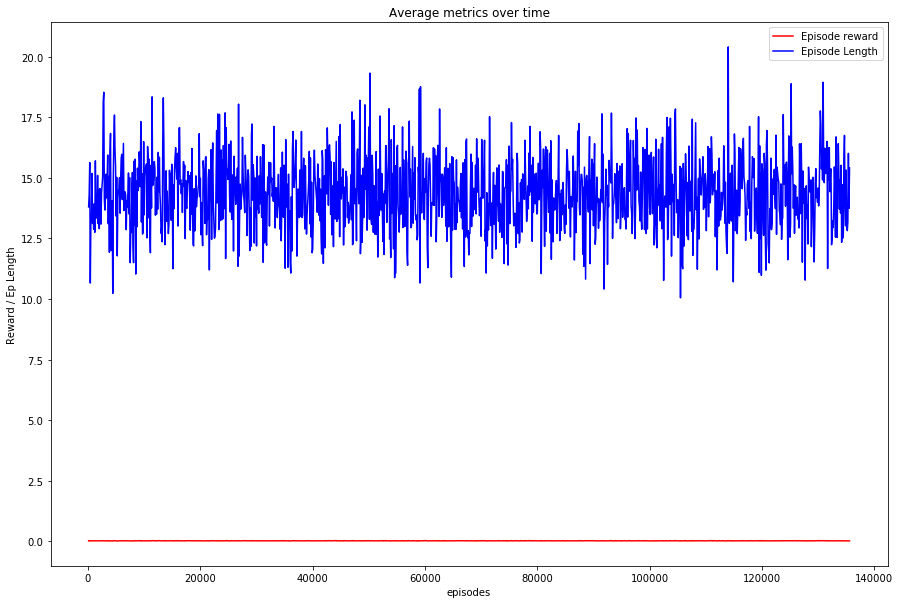

In [21]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

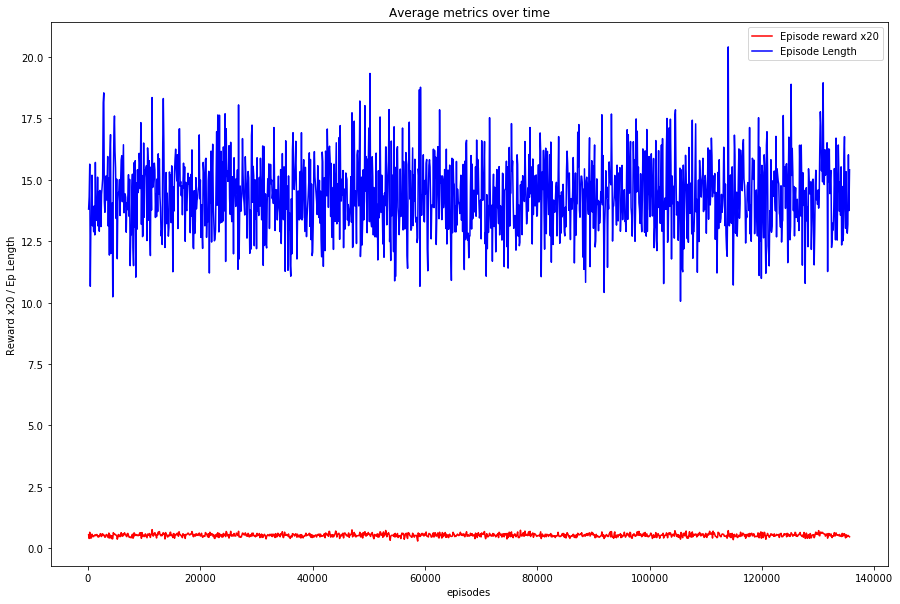

In [22]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

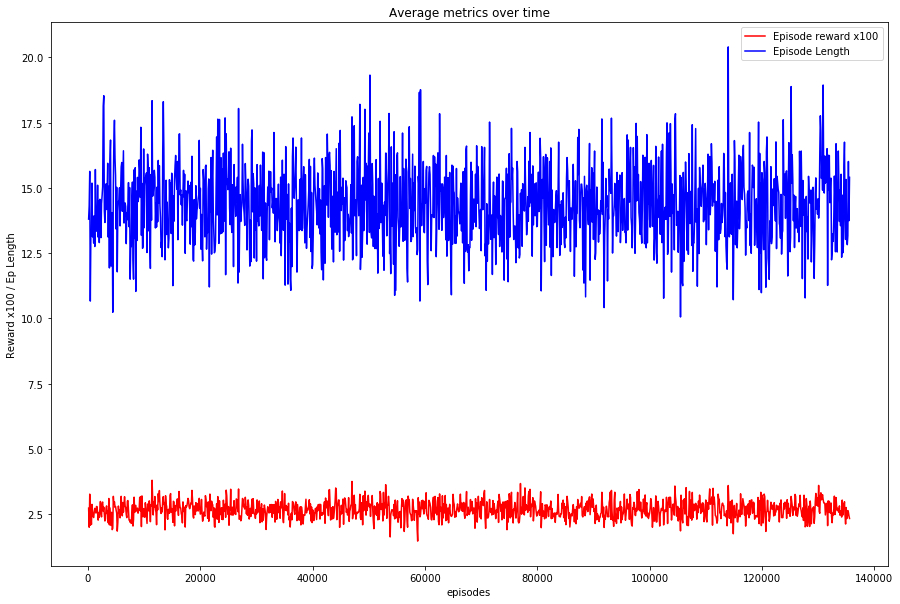

In [23]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

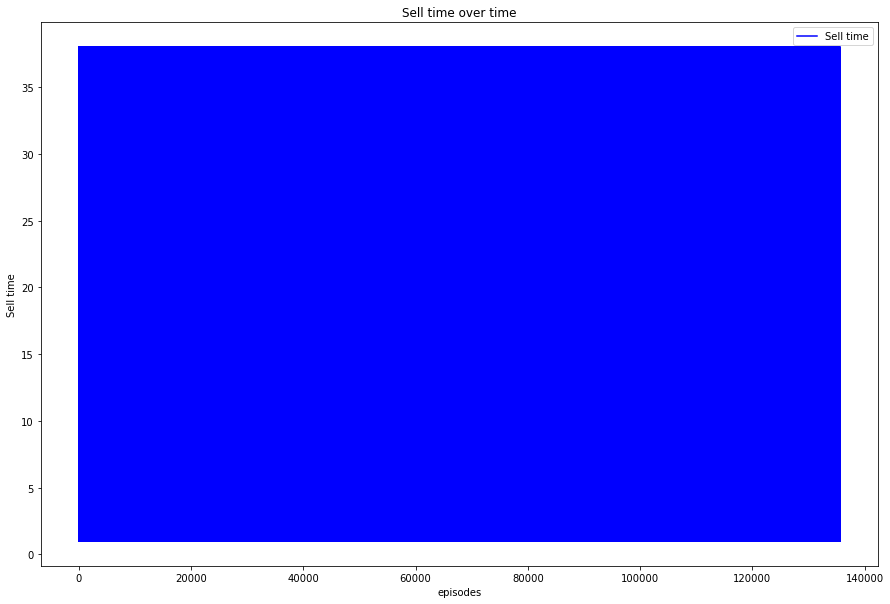

In [24]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

### Validation set

min value of data: 152.40072436906038, max value of data: 233.76779815686893
train_size: 743
test_size: 185
min value of data: 141.69220585131188, max value of data: 224.2618146036533
train_size: 743
test_size: 185
min value of data: 130.8036533100137, max value of data: 207.4614762731008
train_size: 743
test_size: 185
min value of data: 59.36989414885515, max value of data: 102.90875728615067
train_size: 743
test_size: 185
min value of data: 88.32482844060033, max value of data: 127.85678135456038
train_size: 743
test_size: 185
min value of data: 131.8732349738424, max value of data: 188.89924331210884
train_size: 743
test_size: 185
min value of data: 77.90661199501645, max value of data: 126.6348094962481
train_size: 743
test_size: 185
min value of data: 54.63192490207038, max value of data: 97.24646621796207
train_size: 743
test_size: 185
min value of data: 77.95062815511642, max value of data: 173.2507563827493
train_size: 743
test_size: 185
min value of data: 146.10846847083647, m

min value of data: 54.67913922472096, max value of data: 86.93467336683418
train_size: 743
test_size: 185
min value of data: 107.21404250840196, max value of data: 159.17737786925386
train_size: 743
test_size: 185
min value of data: 33.62764968010982, max value of data: 66.0375851110628
train_size: 743
test_size: 185
min value of data: 51.64499464233918, max value of data: 79.16630896556289
train_size: 743
test_size: 185
min value of data: 147.32448164503228, max value of data: 333.5902385961704
train_size: 743
test_size: 185
min value of data: 49.29452676189582, max value of data: 91.73126199887224
train_size: 743
test_size: 185
min value of data: 123.00497374230413, max value of data: 184.16931175766496
train_size: 743
test_size: 185
min value of data: 65.4951999683317, max value of data: 90.14806541217219
train_size: 743
test_size: 185
min value of data: 134.06406942748805, max value of data: 228.18734375557443
train_size: 743
test_size: 185
min value of data: 47.18128871730688, max

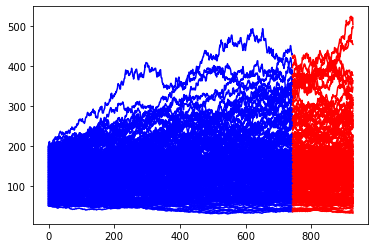

In [26]:
mu = risk_free_rate
#Generate stocks data
stocks_data, _ = GBM(num_seeds, is_training).generate_stock_paths(mu, sigma, 928, num_seeds, is_training)
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_data in stocks_data:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    #train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_data, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r') 

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 750
num_episodes_per_epoch: 24000
min value of stock: 126.41322951712296, max value of stock: 140.16641891411143


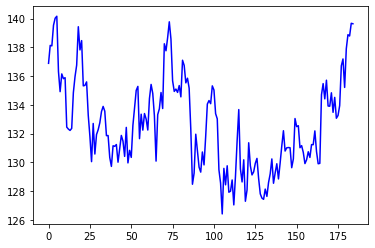

In [27]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

# Select day of price over history bigger than option price (B.M.) [Benchmark]

In [28]:
r = risk_free_rate #10/100
isRiskNeutral = True

In [29]:
begin_time = time.time()

test = 'BM' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:1'):
    set_seed(seed)    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MinValue' or test == 'Normal' or test == 'BM':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MinValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] <= min(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'BM':
              #if j == sell_time and env.get_payoff() > 0:
              T_BM, S0_BM, k_BM, mu_BM, sigma_BM, n_BM = env.getParameters()
              if env.get_time() >= build_warm_up_state_t and env.get_payoff() > 0 and (env.binomialTreeExercise
                (T_BM, S0_BM, k_BM, risk_free_rate, mu_BM, sigma_BM, n_BM, isRiskNeutral)[1] == True or j == max_epLength - 1):
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.034146878876479554	15.28
episode 200: 	0.0236318359608276	13.32
episode 300: 	0.030339900447127862	16.83
episode 400: 	0.020703215458117326	16.34
episode 500: 	0.025702261957620758	16.74
episode 600: 	0.02897925877647921	16.39
episode 700: 	0.030248520743379997	14.89
episode 800: 	0.025894905343882276	13.55
episode 900: 	0.03564211498093445	17.56
episode 1000: 	0.024712828564104044	17.54
episode 1100: 	0.03795141168075552	16.33
episode 1200: 	0.029771756838076563	16.44
episode 1300: 	0.028115638958821066	15.32
episode 1400: 	0.02793935677692697	13.24
episode 1500: 	0.030048034270739533	16.43
episode 1600: 	0.03201294442217282	16.74
episode 1700: 	0.029450980865621305	14.87
episode 1800: 	0.026224489718053176	12.57
episode 1900: 	0.029779275738863357	16.65
episode 2000: 	0.02992893661894916	17.92
episode 2100: 	0.03144419508885446	14.93
episode 2200: 	0.02510321232087517	14.91
episode 2300: 	0.030442174971680933	15.6
episode 2400: 	0.022919374925104635	14.46
episode 2500

episode 19300: 	0.032511131068895555	16.12
episode 19400: 	0.02599571205301253	14.53
episode 19500: 	0.02509792233446159	14.88
episode 19600: 	0.022604198072193635	15.39
episode 19700: 	0.026049919346984352	16.02
episode 19800: 	0.024580993653375505	14.65
episode 19900: 	0.03701677850948577	16.12
episode 20000: 	0.025073137827278748	14.38
#Average reward per episode 20000: 0.028162834952440794
episode 20100: 	0.029121343463666075	15.67
episode 20200: 	0.028776965770470044	15.7
episode 20300: 	0.027827063490554284	12.3
episode 20400: 	0.02558066229955545	13.63
episode 20500: 	0.02629729119848451	15.5
episode 20600: 	0.026388638948928966	13.15
episode 20700: 	0.030280237707768762	16.68
episode 20800: 	0.026310099332794136	12.04
episode 20900: 	0.033184870510340005	16.08
episode 21000: 	0.02575954507204364	14.85
episode 21100: 	0.03217897455677738	16.99
episode 21200: 	0.025686555265230747	13.22
episode 21300: 	0.025079160303773964	13.47
episode 21400: 	0.023693346724401366	14.75
episode 

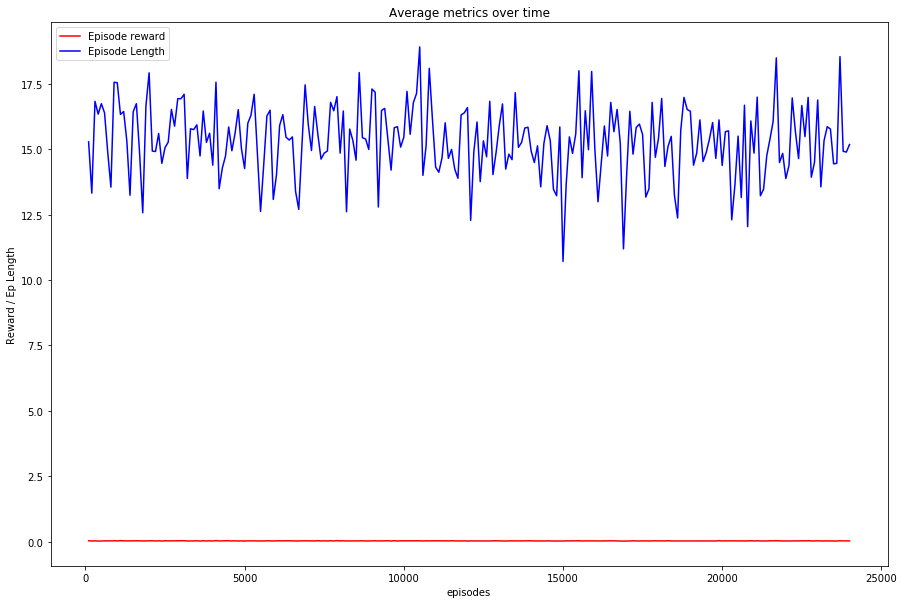

In [30]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

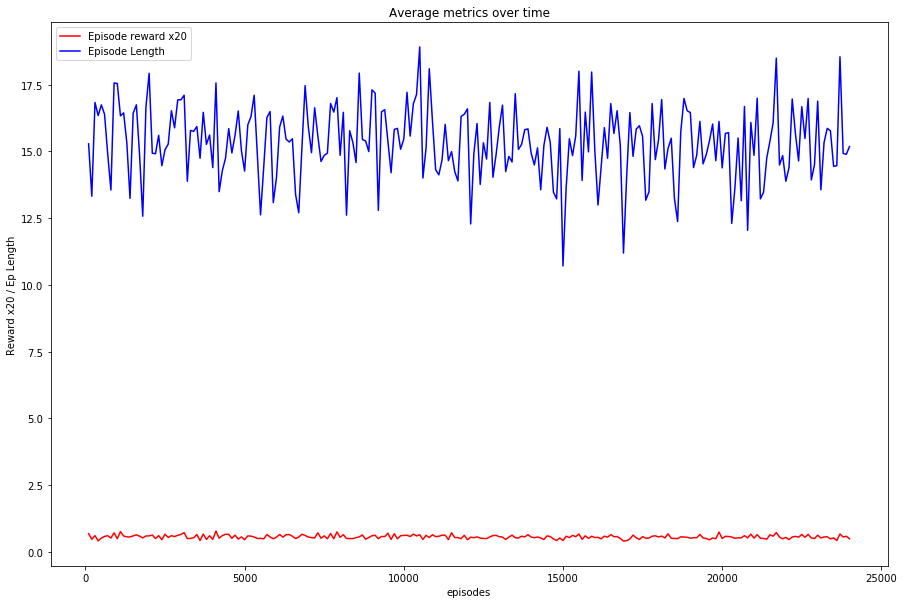

In [31]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

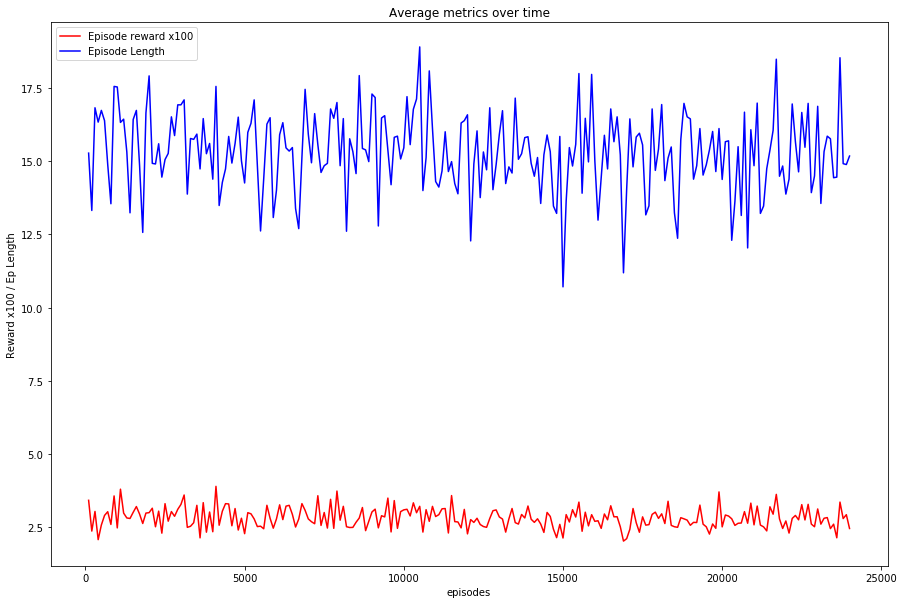

In [32]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

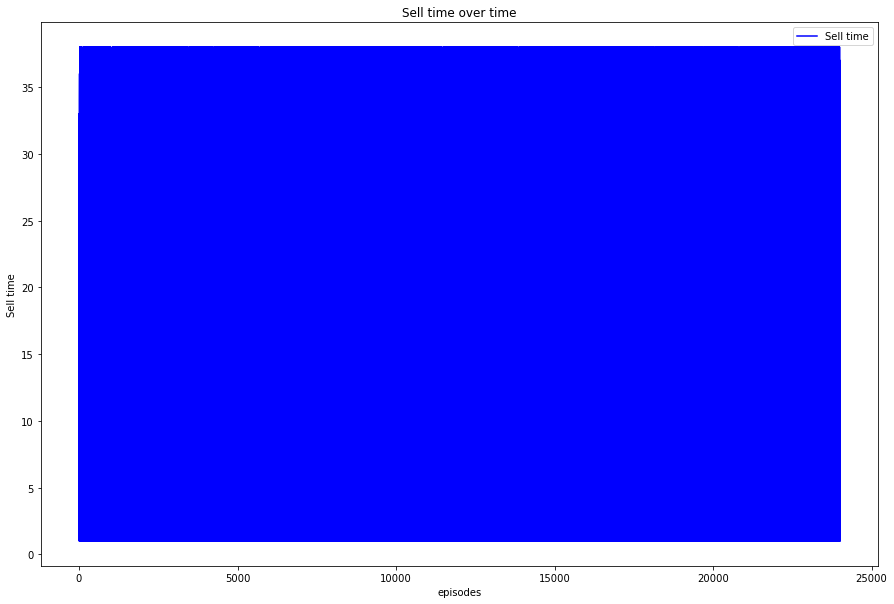

In [33]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Second Valid

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 4237
num_episodes_per_epoch: 135600
min value of stock: 82.18749191096272, max value of stock: 150.4874000630351


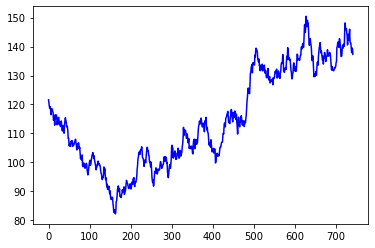

In [34]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

# Select day of price over history bigger than option price (B.M.) [Benchmark]

In [35]:
r = risk_free_rate
isRiskNeutral = True #False

In [36]:
begin_time = time.time()

test = 'BM' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:1'):
    set_seed(seed)    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MinValue' or test == 'Normal' or test == 'BM':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MinValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] <= min(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'BM':
              #if j == sell_time and env.get_payoff() > 0:
              T_BM, S0_BM, k_BM, mu_BM, sigma_BM, n_BM = env.getParameters()
              if env.get_time() >= build_warm_up_state_t and env.get_payoff() > 0 and (env.binomialTreeExercise
                (T_BM, S0_BM, k_BM, risk_free_rate, mu_BM, sigma_BM, n_BM, isRiskNeutral)[1] == True or j == max_epLength - 1):
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.027494495312855954	14.64
episode 200: 	0.024695147913450684	17.51
episode 300: 	0.030501297616908896	16.68
episode 400: 	0.0276292721302719	14.37
episode 500: 	0.02976794998886799	16.02
episode 600: 	0.028584981995897284	14.73
episode 700: 	0.03181747044116292	14.25
episode 800: 	0.03128678853194585	14.74
episode 900: 	0.03138195411686553	14.0
episode 1000: 	0.030164919698985538	13.43
episode 1100: 	0.03129882623187922	15.76
episode 1200: 	0.028473478568207398	14.21
episode 1300: 	0.027216221260470887	14.75
episode 1400: 	0.028743784513898706	16.43
episode 1500: 	0.022215209707351576	12.32
episode 1600: 	0.023755003037994545	13.6
episode 1700: 	0.022175417399446284	12.36
episode 1800: 	0.026899312038896787	15.95
episode 1900: 	0.0239330489209107	15.64
episode 2000: 	0.02425565235476071	14.23
episode 2100: 	0.03045815171713749	15.76
episode 2200: 	0.024685960076112665	12.18
episode 2300: 	0.02391320128444455	14.61
episode 2400: 	0.029350091081708538	15.33
episode 2500: 	

episode 19300: 	0.024741195572871202	15.15
episode 19400: 	0.03200033761694672	16.26
episode 19500: 	0.024947228864071122	16.37
episode 19600: 	0.027856866330261684	17.34
episode 19700: 	0.02890494052248335	14.48
episode 19800: 	0.024746279899871822	13.57
episode 19900: 	0.02753347925723778	13.73
episode 20000: 	0.02569247030691546	14.06
#Average reward per episode 20000: 0.02729142286084871
episode 20100: 	0.02625327149813675	15.02
episode 20200: 	0.026127911412352538	12.44
episode 20300: 	0.028509882695499176	14.96
episode 20400: 	0.023318598906339777	13.09
episode 20500: 	0.024980034498921864	13.4
episode 20600: 	0.025248151317316996	13.65
episode 20700: 	0.02424354317641951	12.06
episode 20800: 	0.025713029346109466	12.79
episode 20900: 	0.025421687570281456	15.16
episode 21000: 	0.026640794116401804	14.63
episode 21100: 	0.0262393200524276	13.26
episode 21200: 	0.0295496508180869	16.68
episode 21300: 	0.025988893398590122	11.75
episode 21400: 	0.032215923129097594	17.35
episode 21

episode 38100: 	0.03141583423319845	14.15
episode 38200: 	0.02578405908911676	13.59
episode 38300: 	0.022587314992089384	12.09
episode 38400: 	0.025783593152100392	14.36
episode 38500: 	0.03417585020468792	15.56
episode 38600: 	0.024219461254939584	13.37
episode 38700: 	0.030323538633795583	13.13
episode 38800: 	0.030524430599233873	16.23
episode 38900: 	0.028188797648712644	14.64
episode 39000: 	0.021398985190105402	12.7
episode 39100: 	0.03327794697576172	16.55
episode 39200: 	0.022515424214342463	13.31
episode 39300: 	0.0206400440744839	13.2
episode 39400: 	0.030619269374362	15.06
episode 39500: 	0.024679799604502218	16.09
episode 39600: 	0.027663135850561765	13.69
episode 39700: 	0.029633932899806828	15.4
episode 39800: 	0.02768485667773253	13.69
episode 39900: 	0.03022736297393164	16.4
episode 40000: 	0.030636778792872865	14.87
#Average reward per episode 40000: 0.027363326950188855
episode 40100: 	0.027234542925265944	14.74
episode 40200: 	0.019688465807590892	11.38
episode 40300

episode 56900: 	0.02505329043602499	14.88
episode 57000: 	0.02572580274165227	12.03
episode 57100: 	0.028184198413313256	14.85
episode 57200: 	0.02420894354565112	12.4
episode 57300: 	0.025103466881649158	13.43
episode 57400: 	0.023791498614521317	14.08
episode 57500: 	0.028819459765197623	16.4
episode 57600: 	0.030985594886701287	14.69
episode 57700: 	0.030093935287719958	15.61
episode 57800: 	0.023965087322921942	14.68
episode 57900: 	0.028115881488519158	16.58
episode 58000: 	0.03374327338087328	17.42
episode 58100: 	0.03055626785322285	15.14
episode 58200: 	0.0305967991609307	12.62
episode 58300: 	0.02752181726225471	14.54
episode 58400: 	0.030453927913607074	17.11
episode 58500: 	0.02876167358177566	15.98
episode 58600: 	0.025856236684167273	14.12
episode 58700: 	0.024714571993570838	15.82
episode 58800: 	0.02385209820835962	12.29
episode 58900: 	0.027198166686583865	14.39
episode 59000: 	0.029580937239869556	15.85
episode 59100: 	0.02906212462160615	13.98
episode 59200: 	0.022095

episode 75700: 	0.0260710968559288	14.7
episode 75800: 	0.027270675320883692	14.99
episode 75900: 	0.028933718226077935	16.34
episode 76000: 	0.03371279960500259	15.15
episode 76100: 	0.030337389115920602	15.48
episode 76200: 	0.02946202805282895	15.61
episode 76300: 	0.024580181129457476	13.32
episode 76400: 	0.034321395783977145	17.06
episode 76500: 	0.02715755040449766	13.93
episode 76600: 	0.023814869962636136	13.6
episode 76700: 	0.027977453618977032	12.33
episode 76800: 	0.025706670679221486	14.18
episode 76900: 	0.02677708972485219	13.73
episode 77000: 	0.025307356092251834	13.71
episode 77100: 	0.029376877696488845	17.03
episode 77200: 	0.026145462431913548	14.44
episode 77300: 	0.027119930439509887	14.91
episode 77400: 	0.028346371458947136	14.85
episode 77500: 	0.02615671993848409	15.12
episode 77600: 	0.027545291322091065	13.86
episode 77700: 	0.02700651986417156	13.68
episode 77800: 	0.02291809167189804	13.3
episode 77900: 	0.027101736133332888	14.86
episode 78000: 	0.02998

episode 94700: 	0.026203105440895314	16.04
episode 94800: 	0.028628593369718503	13.62
episode 94900: 	0.028612240231213008	13.29
episode 95000: 	0.024723154443065668	13.95
#Average reward per episode 95000: 0.027443170196450477
episode 95100: 	0.023478362441498684	14.31
episode 95200: 	0.02715829998934752	14.57
episode 95300: 	0.031310673523049136	14.72
episode 95400: 	0.03308079850837027	18.31
episode 95500: 	0.025965320898510745	14.75
episode 95600: 	0.027197748488452383	16.15
episode 95700: 	0.0280671178336548	13.44
episode 95800: 	0.0406037266150447	18.33
episode 95900: 	0.02985025887205384	15.04
episode 96000: 	0.02588637300605666	13.36
episode 96100: 	0.03341814508625108	16.58
episode 96200: 	0.024369757527385363	13.86
episode 96300: 	0.02722794986788986	13.72
episode 96400: 	0.0243332992868691	13.36
episode 96500: 	0.026459524688180705	14.39
episode 96600: 	0.028957712732949784	15.61
episode 96700: 	0.034140569214091074	16.26
episode 96800: 	0.026641181946493817	15.11
episode 96

episode 113200: 	0.032922274142351104	15.94
episode 113300: 	0.030723160152322765	16.89
episode 113400: 	0.02080584227291451	12.75
episode 113500: 	0.03399978959400234	14.81
episode 113600: 	0.026590674938776992	17.03
episode 113700: 	0.0284301863769157	14.01
episode 113800: 	0.029070428523531335	15.3
episode 113900: 	0.029215303914188365	15.27
episode 114000: 	0.024899319003376618	13.44
episode 114100: 	0.03142631035514392	13.56
episode 114200: 	0.026874030821769278	17.21
episode 114300: 	0.025631711080981473	13.98
episode 114400: 	0.025270106427086915	13.76
episode 114500: 	0.026096717227647007	13.89
episode 114600: 	0.02541982224153945	15.44
episode 114700: 	0.03200620383081791	15.65
episode 114800: 	0.027042299261182522	16.91
episode 114900: 	0.03173437812003855	16.62
episode 115000: 	0.027275177064292708	12.84
#Average reward per episode 115000: 0.027453760794267968
episode 115100: 	0.03023023323001113	14.85
episode 115200: 	0.028151888942491463	16.35
episode 115300: 	0.0339138680

episode 131600: 	0.02662706125870755	16.48
episode 131700: 	0.026340731749564274	16.08
episode 131800: 	0.02858359874749775	15.18
episode 131900: 	0.024778914582410976	15.14
episode 132000: 	0.027080151254376805	13.71
episode 132100: 	0.024950907544592456	12.7
episode 132200: 	0.03239437624470565	15.87
episode 132300: 	0.021822431143196354	12.18
episode 132400: 	0.03172542469427189	16.32
episode 132500: 	0.029050906582282626	15.79
episode 132600: 	0.028870587495369176	16.56
episode 132700: 	0.03117843135307783	15.96
episode 132800: 	0.02021914139438378	12.86
episode 132900: 	0.02571724414119302	12.97
episode 133000: 	0.033580410068583415	16.69
episode 133100: 	0.028025639901219604	15.42
episode 133200: 	0.02143574977627169	13.86
episode 133300: 	0.026856251645928527	15.36
episode 133400: 	0.024158993284469715	13.67
episode 133500: 	0.026477625140090392	14.71
episode 133600: 	0.02757363266711723	15.86
episode 133700: 	0.027835775440359072	14.15
episode 133800: 	0.02343722691855645	13.15

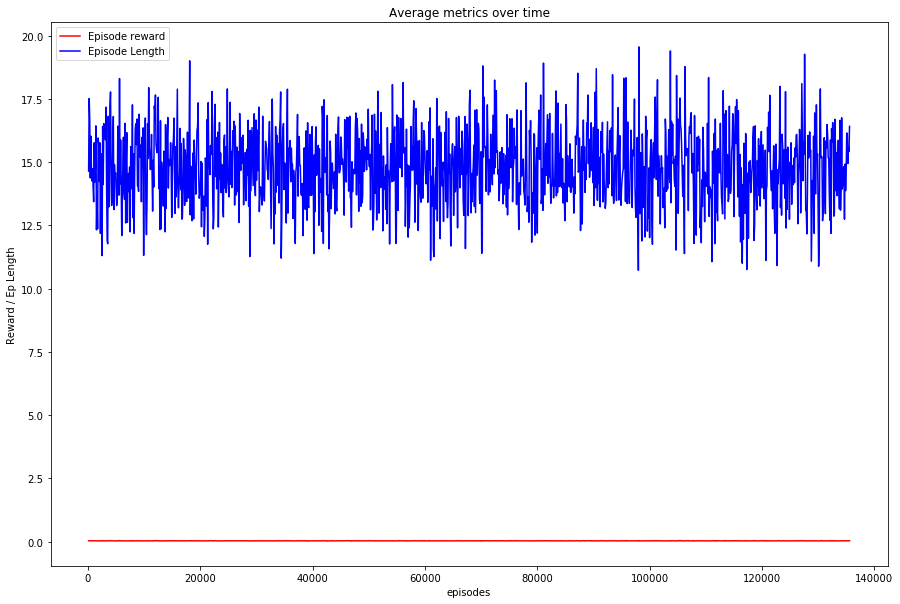

In [37]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

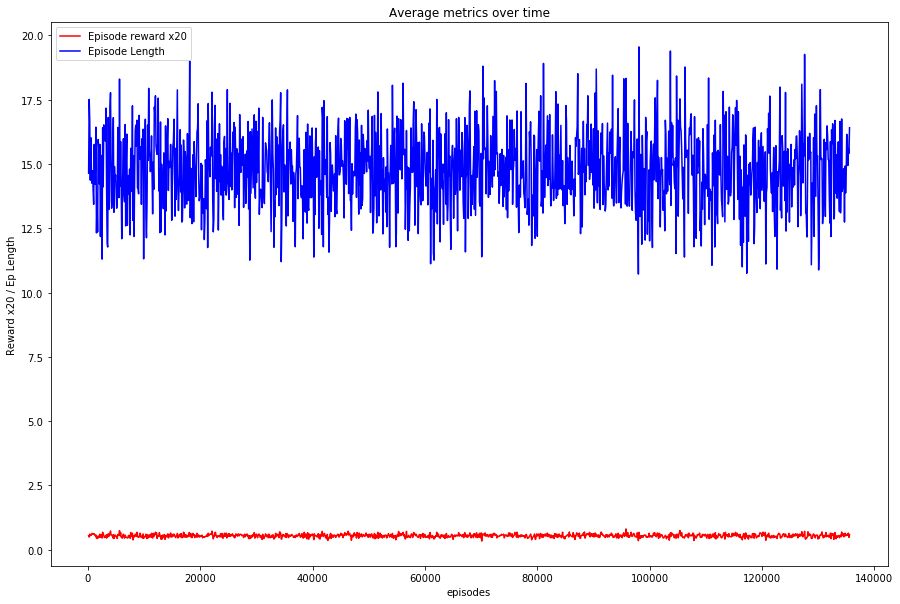

In [38]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

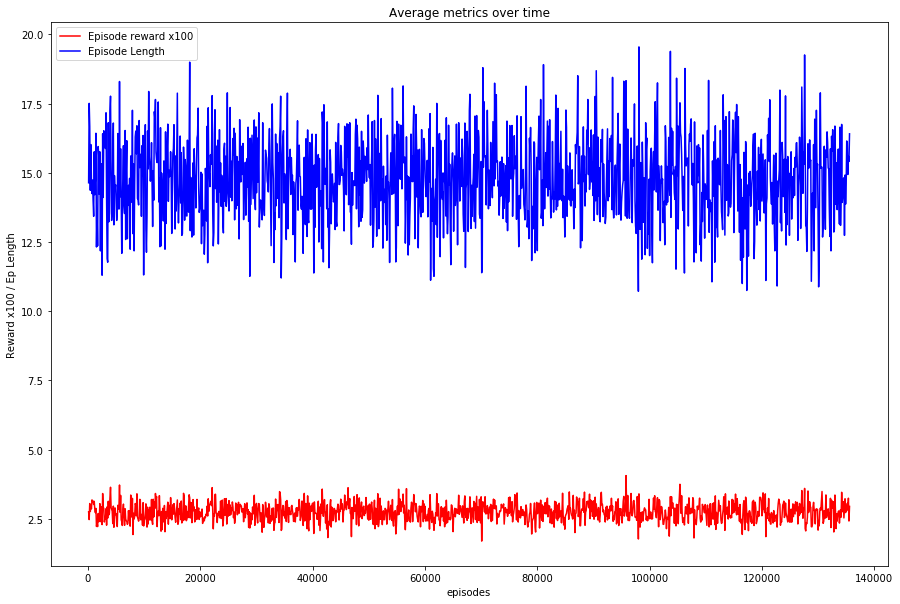

In [39]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

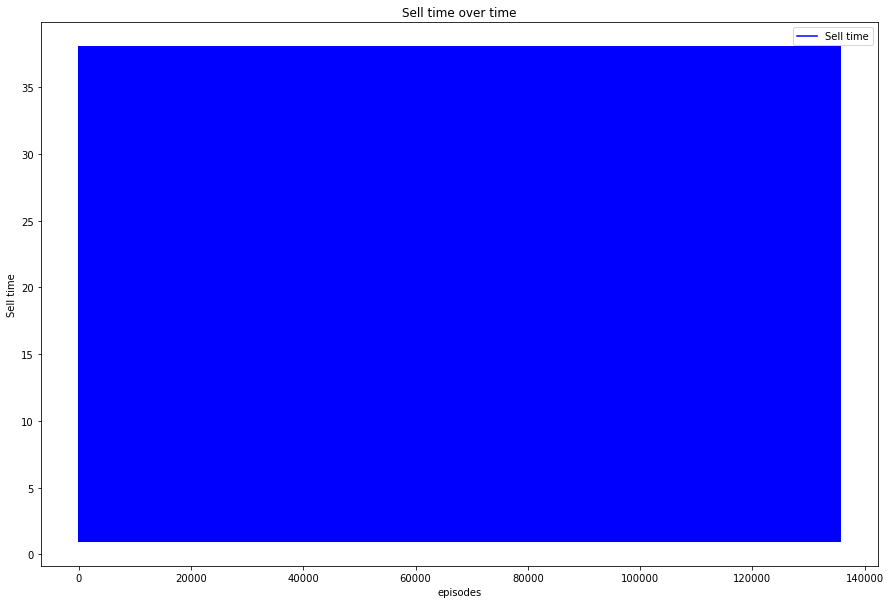

In [40]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Print size of remaining objects

In [41]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
#sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
list_objects = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
#print(list_objects)
for x,y in list_objects:
    print(str(x)+": "+str(y))
    del x

jList: 1174056
maxPossibleOptionP_returnList: 1174056
maxPossibleOptionR_P_returnList: 1174056
maxPossibleP_returnList: 1174056
maxPossibleR_P_returnList: 1174056
maxPossiblerList: 1174056
option_percentage_rList: 1174056
option_real_percentage_rList: 1174056
percentage_rList: 1174056
rList: 1174056
real_percentage_rList: 1174056
sTimeList: 1174056
AvgEpisodeList: 11528
AvgrList: 11528
AvgsTimeList: 11528
stock_data: 7992
real_train_data: 6040
train_data: 6040
real_stocks_test_data: 1680
real_stocks_train_data: 1680
stocks_data: 1680
stocks_test_data: 1680
stocks_train_data: 1680
real_test_data: 1576
test_data: 1576
AmericanOptionPricing: 1064
GBM: 1064
MinMaxScaler: 1064
experience_buffer: 1064
episodeBuffer: 536
final_trained_model_name: 311
trained_model_name: 305
s1P: 232
sP: 232
path: 169
scriptDirectory: 158
build_data: 144
leaky_relu: 144
length: 144
normalize_data: 144
prepare_company_stock: 144
prepare_data: 144
processState: 144
set_seed: 144
updateTarget: 144
updateTargetGra